In [10]:
!pip install svgutils
!pip install ipywidgets

In [16]:
# Cell 1: Imports & Display Helpers
import ipywidgets as widgets
from IPython.display import display
from glayout import gf180
from glayout.primitives.fet import nmos, pmos
from glayout.primitives.mimcap import mimcap
from glayout.primitives.via_gen import via_stack, via_array
from glayout.primitives.guardring import tapring
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.util.comp_utils import evaluate_bbox, prec_center
from glayout.util.port_utils import PortTree, rename_ports_by_orientation
from gdsfactory import Component
import gdstk
import svgutils.transform as sg
import IPython.display

hide = widgets.Output()

def display_gds(gds_file, scale=3):
    top = gdstk.read_gds(gds_file).top_level()[0]
    top.write_svg('out.svg')
    fig = sg.fromfile('out.svg')
    fig.set_size((str(float(fig.width)*scale), str(float(fig.height)*scale)))
    fig.save('out.svg')
    IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale=3):
    with hide:
        component.write_gds('out.gds')
    display_gds('out.gds', scale)

In [17]:
# Cell 2 : NMOS Layout
left = widgets.Output()
leftSPICE = widgets.Output()
grid = widgets.GridspecLayout(1, 2)
grid[0, 0] = left
grid[0, 1] = leftSPICE
display(grid)

comp = nmos(pdk = gf180, fingers=5,with_dnwell=False)
# Display the components GDS and SPICE netlist
with left:
    print('GlobalFoundaries 180nm N-MOSFET (fingers = 5)')
    display_component(comp, scale=2.5)
with leftSPICE:
    print('GlobalFoundaries 180nm SPICE Netlist')
    print(comp.info['netlist'].generate_netlist())

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [18]:
# Cell 3: PMOS Layout
# Used to display the results in a grid (notebook only)
left = widgets.Output()
leftSPICE = widgets.Output()
grid = widgets.GridspecLayout(1, 2)
grid[0, 0] = left
grid[0, 1] = leftSPICE
display(grid)

comp = pmos(pdk=gf180, fingers=5)  # Removed with_dnwell
# Display the components' GDS and SPICE netlists
with left:
    print('GlobalFoundaries 180nm P-MOSFET (fingers = 5)')
    display_component(comp, scale=2.5)
with leftSPICE:
    print('GlobalFoundaries 180nm SPICE Netlist')
    print(comp.info['netlist'].generate_netlist())

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [20]:
# Cell 4: Differential Pair Functions
def diff_pair(pdk, device='nmos', fingers=4, spacing=0.5):
    comp = Component(f"diffpair_{device}")

    # Use user-specified models
    if device == 'nmos':
        fet = nmos(pdk=pdk, fingers=fingers, with_dnwell=False)
    else:
        fet = pmos(pdk=pdk, fingers=fingers)  # No dnwell, no substrate tap

    # Place left and right transistors
    L = comp << fet
    R = comp << fet

    # Symmetric placement
    w = evaluate_bbox(fet)[0]
    L.movex(-w/2 - spacing/2)
    R.movex(+w/2 + spacing/2)

    # Source connection
    comp << straight_route(pdk, L.ports['multiplier_0_source_E'], R.ports['multiplier_0_source_W'])

    # Define ports
    comp.add_port(name='Vbias', port=L.ports['multiplier_0_source_E'])
    comp.add_port(name='Vin+', port=L.ports['multiplier_0_gate_E'])
    comp.add_port(name='Vin-', port=R.ports['multiplier_0_gate_W'])
    comp.add_port(name='Vout+', port=L.ports['multiplier_0_drain_W'])
    comp.add_port(name='Vout-', port=R.ports['multiplier_0_drain_E'])

    return comp

def diff_pair_combined(pdk, fingers=4, spacing=0.5, vgap=2.0):
    comp = Component('diff_pair_combined')

    # Instantiate sub-pairs
    dp_n = diff_pair(pdk, 'nmos', fingers, spacing)
    dp_p = diff_pair(pdk, 'pmos', fingers, spacing)

    # Place NMOS (bottom) and PMOS (top)
    ref_n = comp << dp_n
    ref_p = comp << dp_p

    # Vertical spacing between NMOS and PMOS
    height_n = evaluate_bbox(dp_n)[1]
    ref_p.movey(height_n + vgap)

    # Route outputs from PMOS down to NMOS drains
    comp << c_route(pdk, ref_p.ports['Vout+'], ref_n.ports['Vout+'])
    comp << c_route(pdk, ref_p.ports['Vout-'], ref_n.ports['Vout-'])

    # Define external ports
    comp.add_port(name='Vin+', port=ref_n.ports['Vin+'])
    comp.add_port(name='Vin-', port=ref_n.ports['Vin-'])
    comp.add_port(name='Vbias', port=ref_n.ports['Vbias'])
    comp.add_port(name='VDD', port=ref_p.ports['Vbias']) 
    comp.add_port(name='Vout+', port=ref_n.ports['Vout+'])
    comp.add_port(name='Vout-', port=ref_n.ports['Vout-'])

    return comp

# Cell 5: Current Mirror Function

def currentMirror(pdk, fingers=4):
    comp = Component('current_mirror')

    pf_ref = nmos(pdk=pdk, fingers=fingers, with_dnwell=False)
    pf_mi  = nmos(pdk=pdk, fingers=fingers, with_dnwell=False)

    ref = comp << pf_ref
    mir = comp << pf_mi

    # Horizontal spacing between reference and mirror
    sep = evaluate_bbox(pf_ref)[0] + pdk.util_max_metal_seperation()
    mir.movex(sep)

    # Connect source lines
    comp << straight_route(pdk, ref.ports['multiplier_0_source_E'], mir.ports['multiplier_0_source_E'])

    # Connect gate lines
    comp << straight_route(pdk, ref.ports['multiplier_0_gate_E'], mir.ports['multiplier_0_gate_E'])

    # Connect gate to drain
    comp << c_route(pdk, ref.ports['multiplier_0_gate_E'], ref.ports['multiplier_0_drain_E'])

    # Define ports
    comp.add_port(name='Vs', port=ref.ports['multiplier_0_source_E'])  
    comp.add_port(name='Vin', port=ref.ports['multiplier_0_gate_E'])   
    comp.add_port(name='Iout', port=mir.ports['multiplier_0_drain_E'])

    return comp
    
left = widgets.Output()
right = widgets.Output()
grid = widgets.GridspecLayout(1, 2)
grid[0, 0] = left
grid[0, 1] = right
display(grid)

with left:
    print('Differential Pair')
    dp = diff_pair_combined(gf180, fingers=5)
    display_component(dp, scale=2)

with right:
    print('Current Mirror')
    cm = currentMirror(gf180, fingers=5)
    display_component(cm, scale=2)


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

Full Combined Circuit


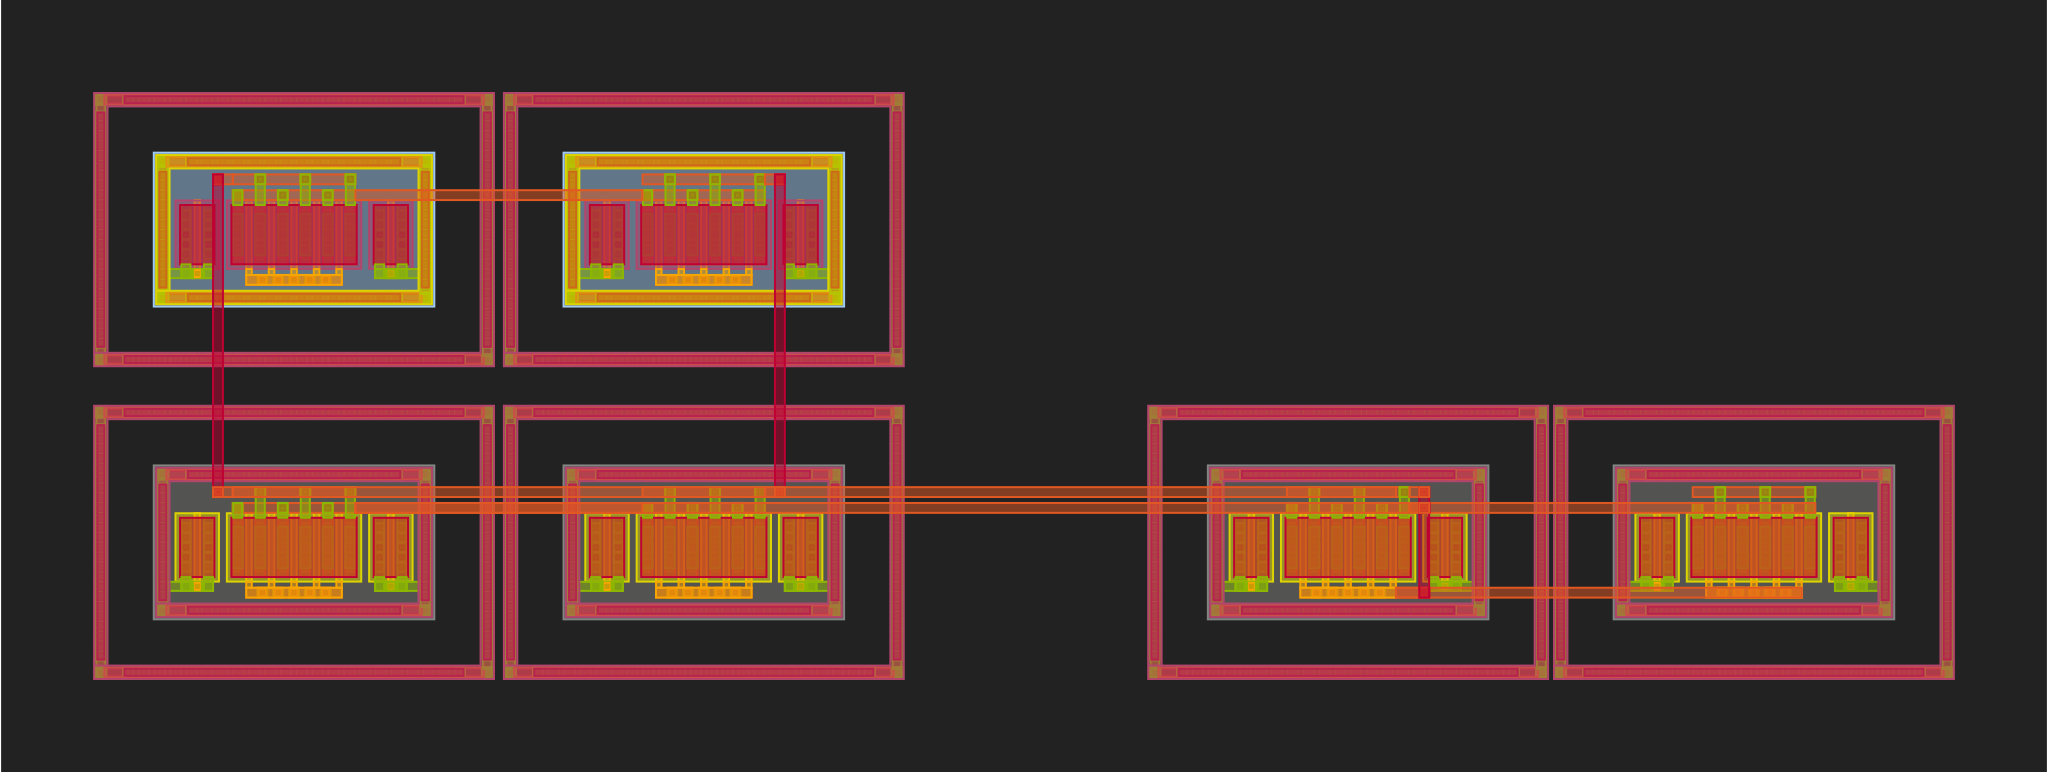

In [22]:
# Cell 6: Interconnection (Routing) between Differential Pair and Current Mirror

top = Component('combined_top')
ref_dp = top << dp
ref_cm = top << cm
w_dp = evaluate_bbox(dp)[0]; ref_cm.movex(w_dp + 2)

top << c_route(gf180, ref_dp.ports['Vbias'], ref_cm.ports['Vs'])
top << straight_route(gf180, ref_dp.ports['Vout+'], ref_cm.ports['Vin'])

top.add_port(name='Vin_dp', port=ref_dp.ports['Vin+'])
top.add_port(name='Vin_cm', port=ref_cm.ports['Vin'])
top.add_port(name='Vbias', port=ref_dp.ports['Vbias'])
top.add_port(name='Vout_dp', port=ref_dp.ports['Vout+'])
top.add_port(name='Vout_cm', port=ref_cm.ports['Vs'])  # output of mirror

print('Full Combined Circuit')
display_component(top, scale=2)

ref_dp ports: dict_keys(['Vin+', 'Vin-', 'Vbias', 'VDD', 'Vout+', 'Vout-'])
Differential Pair + Current Mirror with Pads: Vin+, Vin-, Vcc, I1, GND


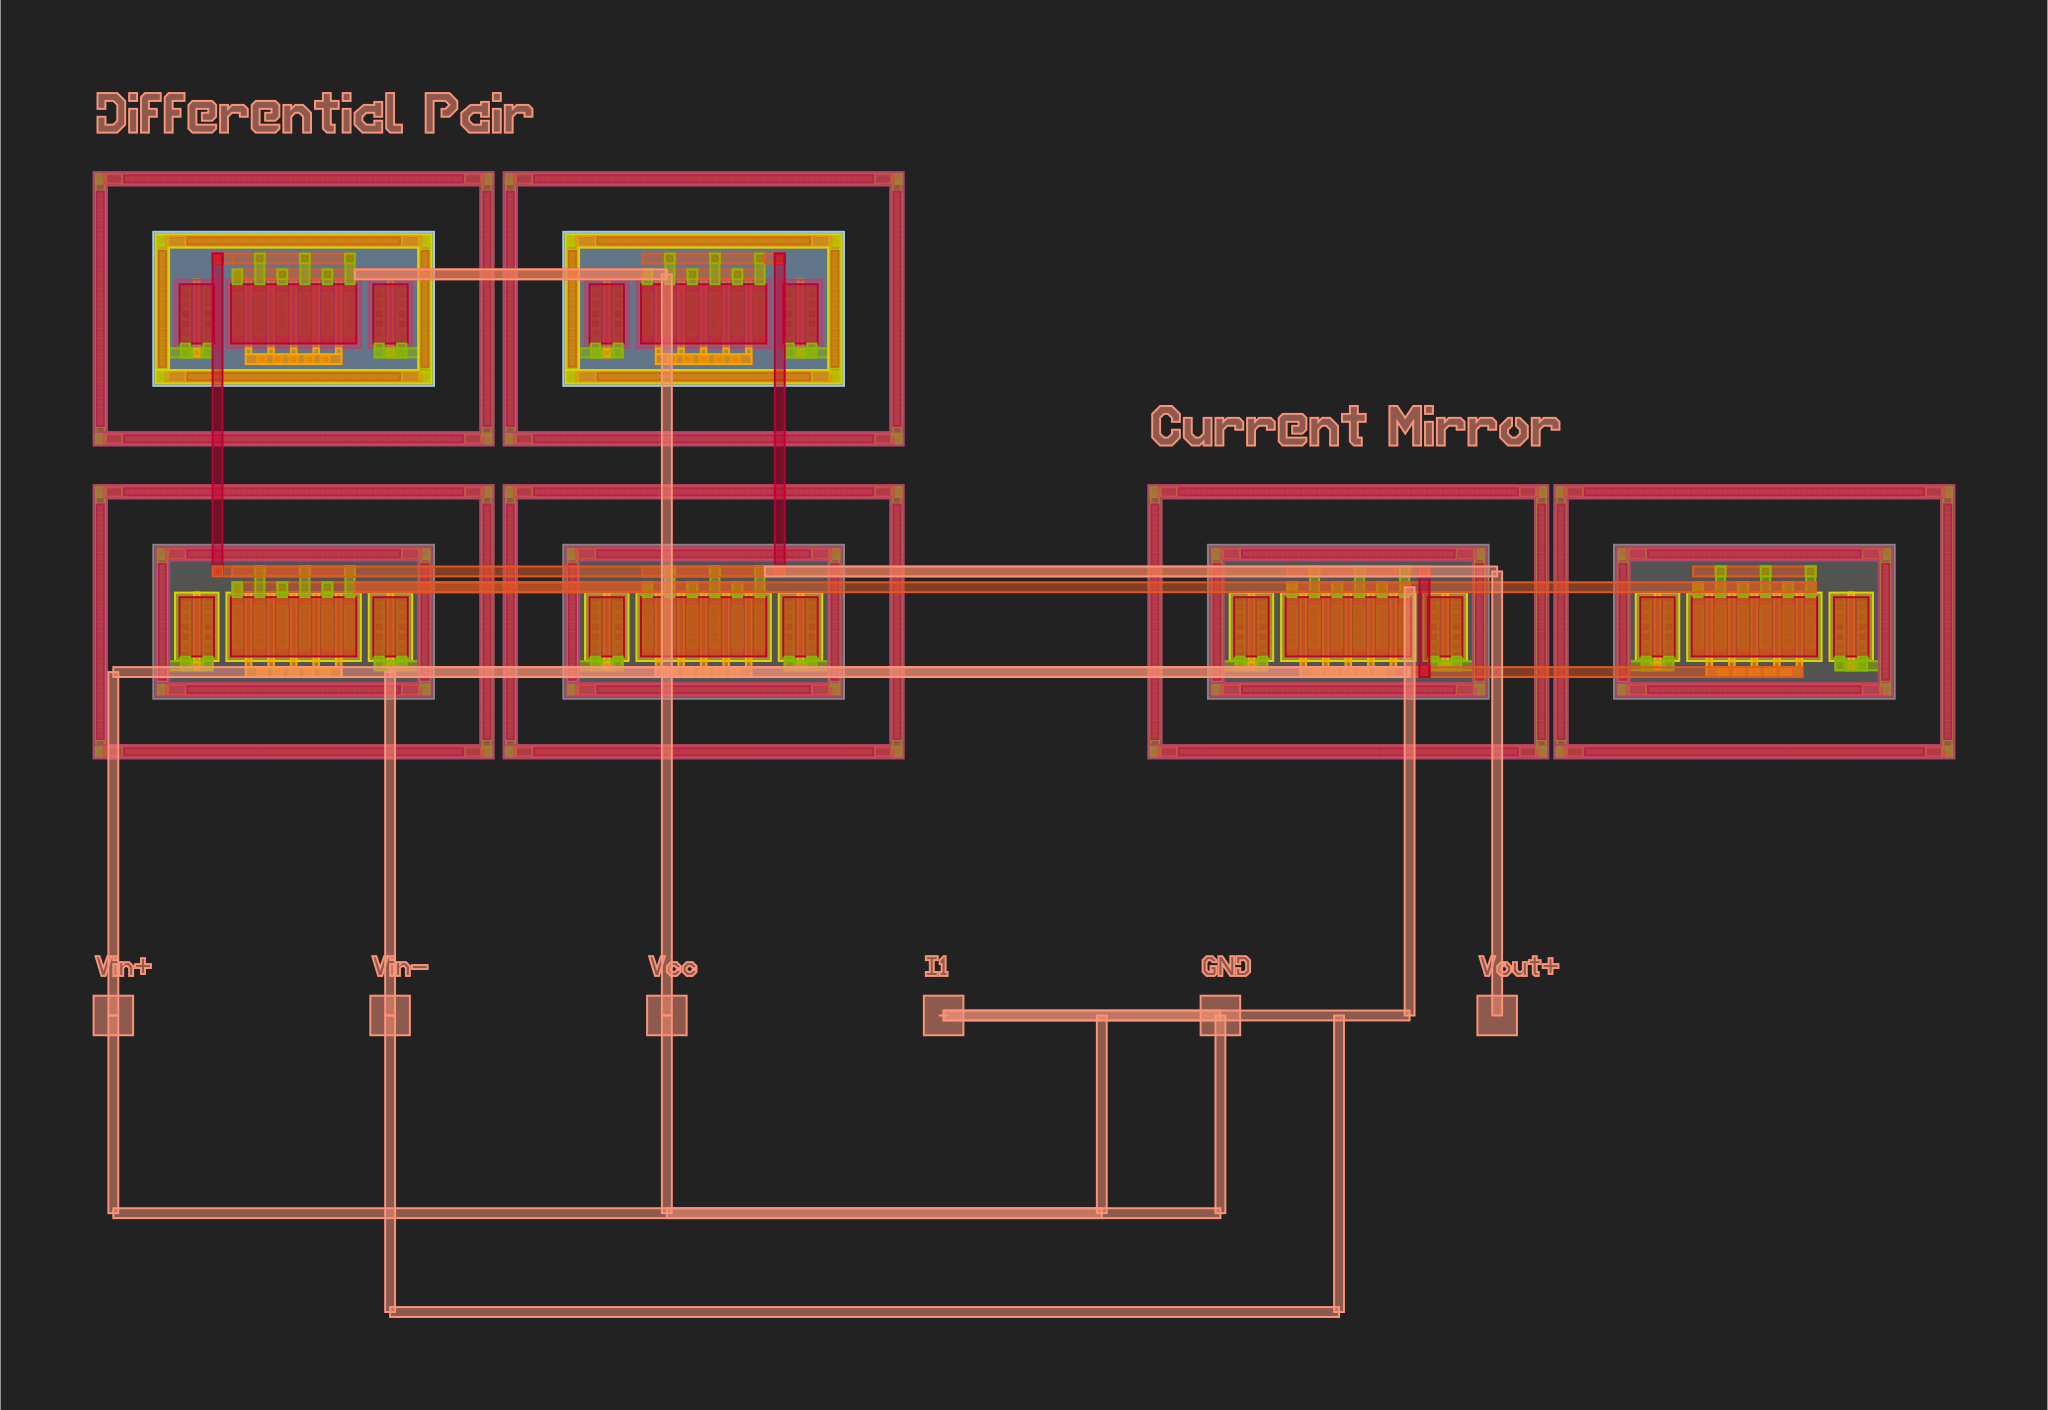

In [21]:
# Cell 7: Full-Routing between cells
from gdsfactory import Component, Port
from gdsfactory.components import rectangle, text

# Create top-level component and place blocks
top1 = Component('dp_cm_with_named_pads')
ref_dp = top1 << dp
ref_cm = top1 << cm
ref_cm.movex(evaluate_bbox(dp)[0] + 2)

# Route internal connections
top1 << straight_route(gf180, ref_dp.ports['Vbias'], ref_cm.ports['Vs'])
top1 << straight_route(gf180, ref_dp.ports['Vout+'], ref_cm.ports['Vin'])

# Add internal access ports
top1.add_port('Vin+', port=ref_dp.ports['Vin+'])
top1.add_port('Vin-', port=ref_dp.ports['Vin-'])
top1.add_port('Vcc', port=ref_dp.ports['VDD'])           # PMOS supply
top1.add_port('I1', port=ref_cm.ports['Vs'])             # current mirror output
top1.add_port("Vout+", port=ref_dp.ports["Vout+"])
# Add GND
xmin, ymin = top1.bbox[0]
gnd_pos = (xmin + 10, ymin - 20)
top1.add_port('GND', port=Port('GND', center=gnd_pos, width=0.5, orientation=90, layer=(68, 20)))

# Add Pad
pad_size = (2, 2)
trace_width = 0.5
pad_layer = (68, 20)
pad_spacing = 12
y_pad = ymin - pad_spacing - pad_size[1]

pad_order = ['Vin+', 'Vin-', 'Vcc', 'I1', 'GND', 'Vout+']

for i, name in enumerate(pad_order):
    x_pos = xmin + i * (pad_size[0] + pad_spacing)
    position = (x_pos, y_pad)
    
    # Pad rectangle
    pad = rectangle(size=pad_size, layer=pad_layer)
    pad_ref = top1 << pad
    pad_ref.move(position)
    
    # Label
    label = text(name, size=1.0, layer=pad_layer)
    label_ref = top1 << label
    label_ref.move((position[0], position[1] + pad_size[1] + 1))
    
    # Add port for pad
    pad_center = pad_ref.center
    top1.add_port(name + '_pad', port=Port(name + '_pad', center=pad_center, width=0.5, orientation=90, layer=pad_layer))

# Routing: Vin+_pad to Vin+
metal_layer = (68, 20)
trace_width = 0.5
# Get coordinates
p1 = top1.ports["Vin+_pad"].center  # pad
p2 = top1.ports["Vin+"].center      # NMOS gate
# Vertical segment up from pad
v_height = abs(p2[1] - p1[1])
v_route = rectangle(size=(trace_width, v_height), layer=metal_layer)
v_ref = top1 << v_route
v_ref.move((p1[0] - trace_width / 2, min(p1[1], p2[1])))
# Horizontal segment to NMOS gate (if needed)
h_width = abs(p2[0] - p1[0])
if h_width > 0:
    h_route = rectangle(size=(h_width, trace_width), layer=metal_layer)
    h_ref = top1 << h_route
    h_ref.move((min(p1[0], p2[0]), p2[1] - trace_width / 2))

# Routing: Vin- pad
p3 = top1.ports["Vin-_pad"].center  # pad center
p4 = top1.ports["Vin-"].center      # NMOS gate
# Vertical segment up from pad
v_height = abs(p4[1] - p3[1])
v_route2 = rectangle(size=(trace_width, v_height), layer=metal_layer)
v_ref2 = top1 << v_route2
v_ref2.move((p3[0] - trace_width / 2, min(p3[1], p4[1])))
# Horizontal segment to NMOS gate
h_width = abs(p4[0] - p3[0])
if h_width > 0:
    h_route2 = rectangle(size=(h_width, trace_width), layer=metal_layer)
    h_ref2 = top1 << h_route2
    h_ref2.move((min(p3[0], p4[0]), p4[1] - trace_width / 2))

# Routing: I1 to GND
trace_width = 0.5
metal_layer = (68, 20)
# Get coordinates
p1 = top1.ports["I1_pad"].center   # from pad
p2 = top1.ports["GND_pad"].center  # to GND pad (not internal port!)
# Step 1: Vertical segment from pad down to GND level
v_height = abs(p2[1] - p1[1])
v_line = rectangle(size=(trace_width, v_height), layer=metal_layer)
v_ref = top1 << v_line
v_ref.move((p1[0] - trace_width / 2, min(p1[1], p2[1])))
# Step 2: Horizontal segment if needed
h_width = abs(p2[0] - p1[0])
if h_width > 0:
    h_line = rectangle(size=(h_width, trace_width), layer=metal_layer)
    h_ref = top1 << h_line
    h_ref.move((min(p1[0], p2[0]), p2[1] - trace_width / 2))

# Routing: I1 to NMOS drain
p_i4 = top1.ports["I1_pad"].center
p_drain = top1.ports["I1"].center
# Horizontal segment
h_width = abs(p_drain[0] - p_i4[0])
if h_width > 0:
    h_route_i4_drain = rectangle(size=(h_width, trace_width), layer=pad_layer)
    h_ref_i4_drain = top1 << h_route_i4_drain
    h_ref_i4_drain.move((min(p_i4[0], p_drain[0]), p_i4[1] - trace_width / 2))
# Vertical segment
v_height = abs(p_drain[1] - p_i4[1])
if v_height > 0:
    v_route_i4_drain = rectangle(size=(trace_width, v_height), layer=pad_layer)
    v_ref_i4_drain = top1 << v_route_i4_drain
    v_ref_i4_drain.move((p_drain[0] - trace_width / 2, min(p_i4[1], p_drain[1])))

# Routing: Vcc to VDD
p1 = top1.ports["Vcc_pad"].center  
p2 = top1.ports["Vcc"].center      
# Vertical segment
v_height = abs(p2[1] - p1[1])
v_route = rectangle(size=(trace_width, v_height), layer=metal_layer)
v_ref = top1 << v_route
v_ref.move((p1[0] - trace_width / 2, min(p1[1], p2[1])))
# Horizontal segment
h_width = abs(p2[0] - p1[0])
if h_width > 0:
    h_route = rectangle(size=(h_width, trace_width), layer=metal_layer)
    h_ref = top1 << h_route
    h_ref.move((min(p1[0], p2[0]), p2[1] - trace_width / 2))

# Routing: VCC to GND
p_vcc = top1.ports["Vcc_pad"].center
p_gnd = top1.ports["GND_pad"].center
# Vertical segment (down)
mid_y = p_vcc[1] - 10  # drop 10 units down (adjust as needed)
v1 = rectangle(size=(trace_width, abs(mid_y - p_vcc[1])), layer=pad_layer)
v1_ref = top1 << v1
v1_ref.move((p_vcc[0] - trace_width / 2, min(p_vcc[1], mid_y)))
# Horizontal segment
h_width = abs(p_vcc[0] - p_gnd[0])
h_seg = rectangle(size=(h_width, trace_width), layer=pad_layer)
h_ref = top1 << h_seg
h_ref.move((min(p_vcc[0], p_gnd[0]), mid_y - trace_width / 2))
# Vertical segment (up)
v2 = rectangle(size=(trace_width, abs(p_gnd[1] - mid_y)), layer=pad_layer)
v2_ref = top1 << v2
v2_ref.move((p_gnd[0] - trace_width / 2, min(p_gnd[1], mid_y)))

# Routing: I1 to Vin+ 
p_i1 = top1.ports["I1"].center
p_vin_plus = top1.ports["Vin+"].center
h_width1 = abs(p_i1[0] - p_vin_plus[0])
h_route1 = rectangle(size=(h_width1, trace_width), layer=metal_layer)
h_ref1 = top1 << h_route1
h_ref1.move((min(p_i1[0], p_vin_plus[0]), p_vin_plus[1] - trace_width / 2))

# Routing: I1 to Vin- 
p_vin_minus = top1.ports["Vin-"].center
h_width2 = abs(p_i1[0] - p_vin_minus[0])
h_route2 = rectangle(size=(h_width2, trace_width), layer=metal_layer)
h_ref2 = top1 << h_route2
h_ref2.move((min(p_i1[0], p_vin_minus[0]), p_vin_minus[1] - trace_width / 2))

# Routing: Vin+ to GND
p_vin_plus = top1.ports["Vin+_pad"].center
p_gnd = top1.ports["GND_pad"].center
mid_y_plus = p_vin_plus[1] - 10
x_detour_plus = p_gnd[0] - 6  
# Vertical segement (down)
v_down_plus = rectangle(size=(trace_width, abs(mid_y_plus - p_vin_plus[1])), layer=metal_layer)
v_ref_down_plus = top1 << v_down_plus
v_ref_down_plus.move((p_vin_plus[0] - trace_width / 2, min(p_vin_plus[1], mid_y_plus)))
# Horizontal segment
h_right_plus = rectangle(size=(abs(p_vin_plus[0] - x_detour_plus), trace_width), layer=metal_layer)
h_ref_right_plus = top1 << h_right_plus
h_ref_right_plus.move((min(p_vin_plus[0], x_detour_plus), mid_y_plus - trace_width / 2))
# Vertical segment (up)
v_up_plus = rectangle(size=(trace_width, abs(p_gnd[1] - mid_y_plus)), layer=metal_layer)
v_ref_up_plus = top1 << v_up_plus
v_ref_up_plus.move((x_detour_plus - trace_width / 2, min(p_gnd[1], mid_y_plus)))

# Routing: Vin- to GND
p_vin_minus = top1.ports["Vin-_pad"].center
mid_y_minus = p_vin_minus[1] - 15  
x_detour_minus = p_gnd[0] + 6      
# Vertical segment (down)
v_down_minus = rectangle(size=(trace_width, abs(mid_y_minus - p_vin_minus[1])), layer=metal_layer)
v_ref_down_minus = top1 << v_down_minus
v_ref_down_minus.move((p_vin_minus[0] - trace_width / 2, min(p_vin_minus[1], mid_y_minus)))
# Horizontal segment
h_right_minus = rectangle(size=(abs(p_vin_minus[0] - x_detour_minus), trace_width), layer=metal_layer)
h_ref_right_minus = top1 << h_right_minus
h_ref_right_minus.move((min(p_vin_minus[0], x_detour_minus), mid_y_minus - trace_width / 2))
# Vertical segment (up)
v_up_minus = rectangle(size=(trace_width, abs(p_gnd[1] - mid_y_minus)), layer=metal_layer)
v_ref_up_minus = top1 << v_up_minus
v_ref_up_minus.move((x_detour_minus - trace_width / 2, min(p_gnd[1], mid_y_minus)))

# Routing: Drain PMOS to Vout+
print("ref_dp ports:", ref_dp.ports.keys())
p1 = ref_dp.ports["Vout-"].center 
p2 = top1.ports["Vout+_pad"].center             
# Horizontal segment
h = rectangle(size=(abs(p1[0] - p2[0]), trace_width), layer=metal_layer)
h_ref = top1 << h
h_ref.move((min(p1[0], p2[0]), p1[1] - trace_width / 2))
# Vertical segment
if p1[1] != p2[1]:
    v = rectangle(size=(trace_width, abs(p1[1] - p2[1])), layer=metal_layer)
    v_ref = top1 << v
    v_ref.move((p2[0] - trace_width / 2, min(p1[1], p2[1])))
        
# Labels For Functional Blocks
# Label Differential Pair (ref_dp)
label_dp = text("Differential Pair", size=2.0, layer=pad_layer)
label_dp_ref = top1 << label_dp
# Place above the DP block
label_dp_ref.move((ref_dp.xmin, ref_dp.ymax + 2))
# Label Current Mirror (ref_cm)
label_cm = text("Current Mirror", size=2.0, layer=pad_layer)
label_cm_ref = top1 << label_cm
# Place above the CM block
label_cm_ref.move((ref_cm.xmin, ref_cm.ymax + 2))

# Save to var
stage1 = top1

# Display Final Layout
print("Differential Pair + Current Mirror with Pads: Vin+, Vin-, Vcc, I1, GND")
display_component(top1, scale=2)

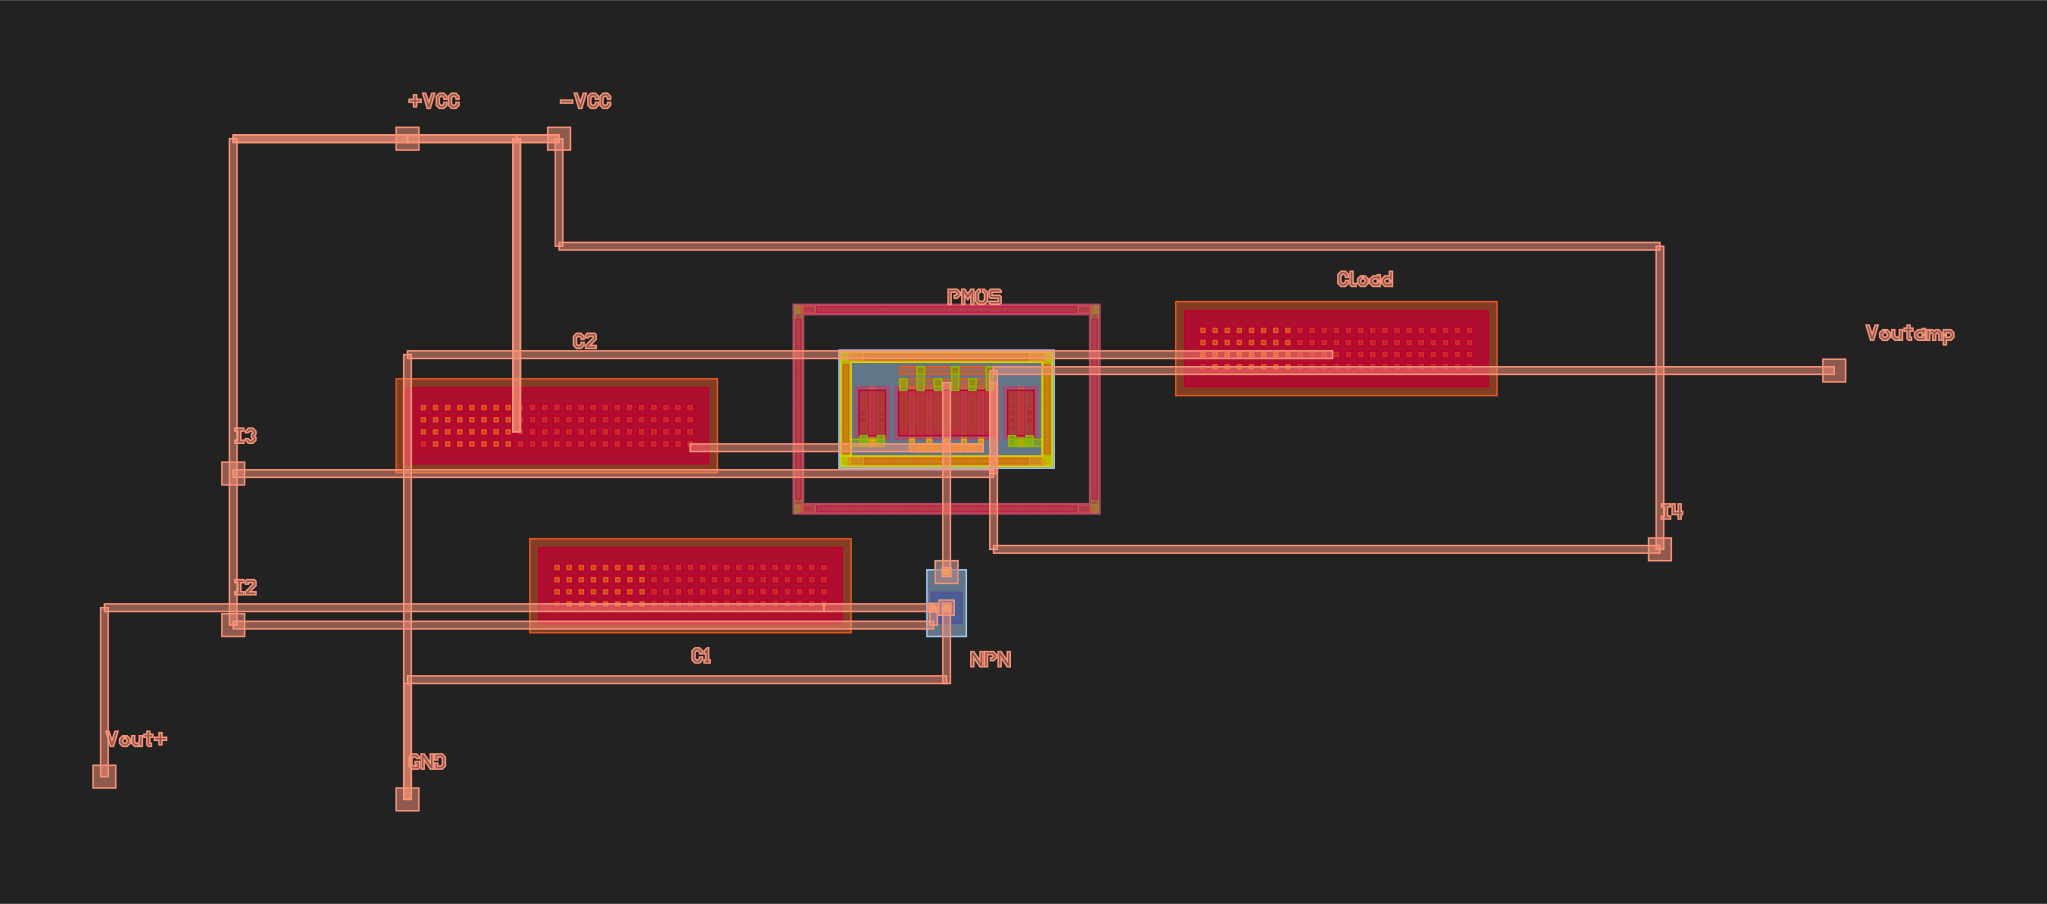

In [24]:
# Cell 8: Routing to MIM Capacitors
import gdsfactory as gf

hide = widgets.Output()

def display_gds(gds_file, scale=3):
    top2 = gdstk.read_gds(gds_file).top_level()[0]
    top2.write_svg("out.svg")
    fig = sg.fromfile("out.svg")
    fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
    fig.save("out_scaled.svg")
    IPython.display.display(IPython.display.SVG("out_scaled.svg"))

def display_component(component, scale=3):
    with hide:
        component.write_gds("out.gds")
    display_gds("out.gds", scale)


# NPN Layout
def create_npn_layout() -> Component:
    LAYER = {
        "nwell":    (41, 0),
        "active":   (47, 0),
        "nplus":    (48, 0),
        "pplus":    (49, 0),
        "contact":  (66, 44),
        "metal1":   (68, 20)
    }

    emitter_size = (1, 1)
    base_enc = 0.5
    collector_size = (1.5, 1.5)
    contact_size = (0.28, 0.28)
    metal_pad = 0.15
    pad = 0.3

    c = Component("npn")

    base_w = emitter_size[0] + 2 * base_enc
    base_h = emitter_size[1] + 2 * base_enc
    collector_y_offset = base_h / 2 + collector_size[1] / 2 + pad

    nwell_w = max(collector_size[0], base_w) + 2 * pad
    nwell_h = base_h + collector_size[1] + 3 * pad
    nwell = c << rectangle(size=(nwell_w, nwell_h), layer=LAYER["nwell"])
    nwell.center = (0, 0)

    base = c << rectangle(size=(base_w, base_h), layer=LAYER["active"])
    base_pplus = c << rectangle(size=(base_w, base_h), layer=LAYER["pplus"])
    base.center = (0, -pad)
    base_pplus.center = base.center

    emitter = c << rectangle(size=emitter_size, layer=LAYER["active"])
    emitter_nplus = c << rectangle(size=emitter_size, layer=LAYER["nplus"])
    emitter.center = base.center
    emitter_nplus.center = emitter.center

    collector = c << rectangle(size=collector_size, layer=LAYER["active"])
    collector_nplus = c << rectangle(size=collector_size, layer=LAYER["nplus"])
    collector.center = (0, collector_y_offset)
    collector_nplus.center = collector.center

    emitter_contact = c << rectangle(size=contact_size, layer=LAYER["contact"])
    emitter_contact.center = emitter.center

    base_contact = c << rectangle(size=contact_size, layer=LAYER["contact"])
    base_contact.center = (base.center[0] - base_w / 2 + contact_size[0] / 2, base.center[1])

    collector_contact = c << rectangle(size=contact_size, layer=LAYER["contact"])
    collector_contact.center = collector.center

    emitter_metal = c << rectangle(size=(contact_size[0] + 2 * metal_pad, contact_size[1] + 2 * metal_pad),
                                   layer=LAYER["metal1"])
    emitter_metal.center = emitter_contact.center

    base_metal = c << rectangle(size=(contact_size[0] + 2 * metal_pad, contact_size[1] + 2 * metal_pad),
                                layer=LAYER["metal1"])
    base_metal.center = base_contact.center

    collector_metal = c << rectangle(size=(contact_size[0] + 2 * metal_pad, contact_size[1] + 2 * metal_pad),
                                     layer=LAYER["metal1"])
    collector_metal.center = collector_contact.center

    c.add_port("E", center=emitter_metal.center, width=0.5, orientation=270, layer=LAYER["metal1"])
    c.add_port("B", center=base_metal.center, width=0.5, orientation=180, layer=LAYER["metal1"])
    c.add_port("C", center=collector_metal.center, width=0.5, orientation=90,  layer=LAYER["metal1"])

    return c

top2 = Component("mim-npn-pmos-mim")

# Create NPN
npn = create_npn_layout()
npn_ref = top2 << npn

# Place MIM capacitor to base of NPN
mim1 = mimcap(pdk=gf180, size=[20.0, 5.0])
mim1_ref = top2 << mim1
mim1_top_port = [p for p in mim1_ref.ports if p.endswith("_top_met_S")][0]
mim1_ref.xmax = npn_ref.xmin - 5
mim1_ref.movey(npn_ref.ports["B"].center[1] - mim1_ref.ports[mim1_top_port].center[1])

# Wire from MIM1 to NPN base
x1 = mim1_ref.ports[mim1_top_port].center[0]
x2 = npn_ref.ports["B"].center[0]
y = mim1_ref.ports[mim1_top_port].center[1]
wire1 = top2 << rectangle(size=(abs(x2 - x1), 0.5), layer=(68, 20))
wire1.move((min(x1, x2), y - 0.25))

# Place PMOS above NPN
pmos_ref = top2 << pmos(pdk=gf180, fingers=5)
pmos_ref.movex(npn_ref.center[0] - pmos_ref.center[0])
pmos_ref.movey(npn_ref.ymax + 10)

# Wire NPN collector to PMOS source
npn_c = npn_ref.ports["C"]
pmos_s = pmos_ref.ports["multiplier_0_source_E"]
dy = pmos_s.center[1] - npn_c.center[1]
metal_layer = (68, 20)
wire2 = top2 << rectangle(size=(0.5, abs(dy)), layer=metal_layer)
wire2.move((npn_c.center[0] - 0.25, npn_c.center[1]))

# Place MIM2 to left of PMOS gate
mim2 = mimcap(pdk=gf180, size=[20.0, 5.0])
mim2_ref = top2 << mim2
mim2_top_port = [p for p in mim2_ref.ports if p.endswith("_top_met_S")][0]
pmos_gate = pmos_ref.ports["multiplier_0_gate_E"]
mim2_ref.xmax = pmos_ref.xmin - 5
mim2_ref.movey(pmos_gate.center[1] - mim2_ref.ports[mim2_top_port].center[1])

# Wire MIM2 to gate
x3 = mim2_ref.ports[mim2_top_port].center[0]
x4 = pmos_gate.center[0]
y2 = mim2_ref.ports[mim2_top_port].center[1]
wire3 = top2 << rectangle(size=(abs(x4 - x3), 0.5), layer=metal_layer)
wire3.move((min(x3, x4), y2 - 0.25))

# Place MIM3 to right of PMOS drain
mim3 = mimcap(pdk=gf180, size=[20.0, 5.0])
mim3_ref = top2 << mim3
mim3_top_port = [p for p in mim3_ref.ports if p.endswith("_top_met_S")][0]
pmos_drain = pmos_ref.ports["multiplier_0_drain_E"]
mim3_ref.xmin = pmos_ref.xmax + 5
mim3_ref.movey(pmos_drain.center[1] - mim3_ref.ports[mim3_top_port].center[1])

# Wire PMOS drain to MIM3
x5 = pmos_drain.center[0]
x6 = mim3_ref.ports[mim3_top_port].center[0]
y3 = mim3_ref.ports[mim3_top_port].center[1]
wire4 = top << rectangle(size=(abs(x6 - x5), 0.5), layer=metal_layer)
wire4.move((min(x5, x6), y3 - 0.25))

# Add Pads with Labels
pad_size = (1.5, 1.5)
pad_layer = (68, 20)
pad_spacing = 10

def add_pad_with_label(name, position, label_offset=(0, 2)):
    pad = rectangle(size=pad_size, layer=pad_layer)
    ref = top2 << pad
    ref.move(position)
    top2.add_port(name, port=Port(name=name, center=ref.center, width=0.5, orientation=90, layer=pad_layer))
    label = text(text=name, size=1.0, layer=pad_layer)
    label_ref = top2 << label
    label_ref.move((ref.center[0] + label_offset[0], ref.center[1] + label_offset[1]))
    return ref

xmin, ymin = top2.bbox[0]
xmax, ymax = top2.bbox[1]

add_pad_with_label("+VCC", position=(xmin + 0, ymax + pad_spacing))
add_pad_with_label("-VCC", position=(xmin + 10, ymax + pad_spacing))
add_pad_with_label("GND", position=(xmin + 0, ymin - pad_spacing - pad_size[1]))
add_pad_with_label("I2", position=(xmin - pad_spacing - pad_size[0], ymin + 0))
add_pad_with_label("I3", position=(xmin - pad_spacing - pad_size[0], ymin + 10))
add_pad_with_label("I4", position=(xmax + pad_spacing, ymin + 5))
add_pad_with_label("Vout+", position=(xmin-20, ymin-10))

# Routing: +VCC to I3
trace_width = 0.5
p1 = top2.ports["+VCC"].center
p2 = top2.ports["I3"].center
h_width = abs(p2[0] - p1[0])
if h_width > 0:
    h_route = rectangle(size=(h_width, trace_width), layer=pad_layer)
    h_ref = top2 << h_route
    h_ref.move((min(p1[0], p2[0]), p1[1] - trace_width / 2))

# Routing: +VCC to I2
trace_width = 0.5
p1 = top2.ports["+VCC"].center
p2 = top2.ports["I2"].center
# Horizontal segment
h_width = abs(p2[0] - p1[0])
if h_width > 0:
    h_route = rectangle(size=(h_width, trace_width), layer=pad_layer)
    h_ref = top2 << h_route
    h_ref.move((min(p1[0], p2[0]), p1[1] - trace_width / 2))
# vertical segment
v_height = abs(p2[1] - p1[1])
if v_height > 0:
    v_route = rectangle(size=(trace_width, v_height), layer=pad_layer)
    v_ref = top2 << v_route
    v_ref.move((p2[0] - trace_width / 2, min(p1[1], p2[1])))

# Routing: I3 to PMOS source
p3 = top2.ports["I3"].center
p4 = pmos_ref.ports["multiplier_0_source_E"].center
# Horizontal segment
h_width = abs(p4[0] - p3[0])
if h_width > 0:
    h_route2 = rectangle(size=(h_width, trace_width), layer=pad_layer)
    h_ref2 = top2 << h_route2
    h_ref2.move((min(p3[0], p4[0]), p3[1] - trace_width / 2))
# Vertical segment
v_height = abs(p4[1] - p3[1])
if v_height > 0:
    v_route2 = rectangle(size=(trace_width, v_height), layer=pad_layer)
    v_ref2 = top2 << v_route2
    v_ref2.move((p4[0] - trace_width / 2, min(p3[1], p4[1])))


# Routing: I4 to PMOS drain
p_i4 = top2.ports["I4"].center
p_drain = pmos_ref.ports["multiplier_0_drain_E"].center
# Horizontal segment
h_width = abs(p_drain[0] - p_i4[0])
if h_width > 0:
    h_route_i4_drain = rectangle(size=(h_width, trace_width), layer=pad_layer)
    h_ref_i4_drain = top2 << h_route_i4_drain
    h_ref_i4_drain.move((min(p_i4[0], p_drain[0]), p_i4[1] - trace_width / 2))
# Vertical segment
v_height = abs(p_drain[1] - p_i4[1])
if v_height > 0:
    v_route_i4_drain = rectangle(size=(trace_width, v_height), layer=pad_layer)
    v_ref_i4_drain = top2 << v_route_i4_drain
    v_ref_i4_drain.move((p_drain[0] - trace_width / 2, min(p_i4[1], p_drain[1])))

# Routing: I4 to -VCC
p_i4 = top2.ports["I4"].center
p_vcc_neg = top2.ports["-VCC"].center
# vertical segment (up)
up_y = p_i4[1] + 20  # Adjust height as needed
v_up = top2 << rectangle(size=(trace_width, abs(up_y - p_i4[1])), layer=pad_layer)
v_up.move((p_i4[0] - trace_width / 2, min(p_i4[1], up_y)))
# Horizontall segment
h_left = top2 << rectangle(size=(abs(p_i4[0] - p_vcc_neg[0]), trace_width), layer=pad_layer)
h_left.move((min(p_i4[0], p_vcc_neg[0]), up_y - trace_width / 2))
# Vertical segment (down)
v_down = top2 << rectangle(size=(trace_width, abs(up_y - p_vcc_neg[1])), layer=pad_layer)
v_down.move((p_vcc_neg[0] - trace_width / 2, min(up_y, p_vcc_neg[1])))

# Routing: -VCC to +VCC
p_vcc_pos = top2.ports["+VCC"].center
p_vcc_neg = top2.ports["-VCC"].center
# Horizontal segment
h_width = abs(p_vcc_pos[0] - p_vcc_neg[0])
if h_width > 0:
    h_route_vcc = rectangle(size=(h_width, trace_width), layer=pad_layer)
    h_ref_vcc = top2 << h_route_vcc
    h_ref_vcc.move((min(p_vcc_pos[0], p_vcc_neg[0]), p_vcc_pos[1] - trace_width / 2))
# Vertical segment
v_height = abs(p_vcc_pos[1] - p_vcc_neg[1])
if v_height > 0:
    v_route_vcc = rectangle(size=(trace_width, v_height), layer=pad_layer)
    v_ref_vcc = top2 << v_route_vcc
    v_ref_vcc.move((p_vcc_pos[0] - trace_width / 2, min(p_vcc_pos[1], p_vcc_neg[1])))

# Identify bottom port of MIM2
mim2_bot_key = [k for k in mim2_ref.ports if "bot" in k.lower()][0]
mim2_bot = mim2_ref.ports[mim2_bot_key]
p_bot = mim2_bot.center

# Routing: +VCC and -VCC to bottom of MIM2 (center cell)
mim2_bot_center_port = mim2_ref.ports["array_row1_col8_bottom_met_W"]
p_bot = mim2_bot_center_port.center

# From +VCC
p_vcc_pos = top2.ports["+VCC"].center
h1 = abs(p_vcc_pos[0] - p_bot[0])
if h1 > 0:
    r1 = top2 << rectangle(size=(h1, trace_width), layer=pad_layer)
    r1.move((min(p_vcc_pos[0], p_bot[0]), p_vcc_pos[1] - trace_width / 2))
v1 = abs(p_vcc_pos[1] - p_bot[1])
if v1 > 0:
    r1v = top2 << rectangle(size=(trace_width, v1), layer=pad_layer)
    r1v.move((p_bot[0] - trace_width / 2, min(p_vcc_pos[1], p_bot[1])))

# From -VCC
p_vcc_neg = top2.ports["-VCC"].center
h2 = abs(p_vcc_neg[0] - p_bot[0])
if h2 > 0:
    r2 = top2 << rectangle(size=(h2, trace_width), layer=pad_layer)
    r2.move((min(p_vcc_neg[0], p_bot[0]), p_vcc_neg[1] - trace_width / 2))
v2 = abs(p_vcc_neg[1] - p_bot[1])
if v2 > 0:
    r2v = top2 << rectangle(size=(trace_width, v2), layer=pad_layer)
    r2v.move((p_bot[0] - trace_width / 2, min(p_vcc_neg[1], p_bot[1])))

# Routing: I2 to NPN base
p_i2 = top2.ports["I2"].center
p_base = npn_ref.ports["B"].center
# Horizontal segment
h_width = abs(p_i2[0] - p_base[0])
if h_width > 0:
    h_route = rectangle(size=(h_width, trace_width), layer=pad_layer)
    h_ref = top2 << h_route
    h_ref.move((min(p_i2[0], p_base[0]), p_i2[1] - trace_width / 2))
# Vertical segment
v_height = abs(p_i2[1] - p_base[1])
if v_height > 0:
    v_route = rectangle(size=(trace_width, v_height), layer=pad_layer)
    v_ref = top2 << v_route
    v_ref.move((p_base[0] - trace_width / 2, min(p_i2[1], p_base[1])))

# Routing:: bottom of MIM3 (PMOS drain capacitor) to GND
mim3_bot_center_port = mim3_ref.ports["array_row1_col11_bottom_met_W"]
p_mim3_bot = mim3_bot_center_port.center
p_gnd = top2.ports["GND"].center
# Horizontal segment
h_width = abs(p_gnd[0] - p_mim3_bot[0])
if h_width > 0:
    h_route = rectangle(size=(h_width, trace_width), layer=pad_layer)
    h_ref = top2 << h_route
    h_ref.move((min(p_gnd[0], p_mim3_bot[0]), p_mim3_bot[1] - trace_width / 2))
# Vertical segment
v_height = abs(p_gnd[1] - p_mim3_bot[1])
if v_height > 0:
    v_route = rectangle(size=(trace_width, v_height), layer=pad_layer)
    v_ref = top2 << v_route
    v_ref.move((p_gnd[0] - trace_width / 2, min(p_gnd[1], p_mim3_bot[1])))

# Routing: NPN emitter to GND
p_emitter = npn_ref.ports["E"].center
p_gnd = top2.ports["GND"].center

drop_y = p_emitter[1] - 5 
v_drop = top2 << rectangle(size=(trace_width, abs(p_emitter[1] - drop_y)), layer=pad_layer)
v_drop.move((p_emitter[0] - trace_width / 2, drop_y))
h_width = abs(p_gnd[0] - p_emitter[0])
h_route = top2 << rectangle(size=(h_width, trace_width), layer=pad_layer)
h_route.move((min(p_gnd[0], p_emitter[0]), drop_y))

v_height = abs(drop_y - p_gnd[1])
v_final = top2 << rectangle(size=(trace_width, v_height), layer=pad_layer)
v_final.move((p_gnd[0] - trace_width / 2, min(drop_y, p_gnd[1])))

# Routing: MIM1 to Vout+
p_mim1_top = mim1_ref.ports[mim1_top_port].center
p_vout_plus = top2.ports["Vout+"].center
# Horizontal segment
h_mim1 = rectangle(size=(abs(p_mim1_top[0] - p_vout_plus[0]), trace_width), layer=pad_layer)
h_mim1_ref = top2 << h_mim1
h_mim1_ref.move((min(p_mim1_top[0], p_vout_plus[0]), p_mim1_top[1] - trace_width / 2))
# Vertical segment
if p_mim1_top[1] != p_vout_plus[1]:
    v_mim1 = rectangle(size=(trace_width, abs(p_mim1_top[1] - p_vout_plus[1])), layer=pad_layer)
    v_mim1_ref = top2 << v_mim1
    v_mim1_ref.move((p_vout_plus[0] - trace_width / 2, min(p_mim1_top[1], p_vout_plus[1])))

# Create Voutamp pad
voutamp_pos = (top2.bbox[1][0] + 10, pmos_ref.ports["multiplier_0_drain_E"].center[1])
voutamp = rectangle(size=pad_size, layer=pad_layer)
voutamp_ref = top2 << voutamp
voutamp_ref.move((voutamp_pos[0] - pad_size[0]/2, voutamp_pos[1] - pad_size[1]/2))

top2.add_port("Voutamp", port=Port(name="Voutamp", center=voutamp_ref.center, width=0.5, orientation=0, layer=pad_layer))

voutamp_label = text(text="Voutamp", size=1.0, layer=pad_layer)
voutamp_label_ref = top2 << voutamp_label
voutamp_label_ref.move((voutamp_ref.center[0] + 2, voutamp_ref.center[1] + 2))

# Routing: PMOS drain to Voutamp pad
p_drain = pmos_ref.ports["multiplier_0_drain_E"].center
p_voutamp = top2.ports["Voutamp"].center
# Horizontal segment
h_pmos = rectangle(size=(abs(p_drain[0] - p_voutamp[0]), trace_width), layer=pad_layer)
h_pmos_ref = top2 << h_pmos
h_pmos_ref.move((min(p_drain[0], p_voutamp[0]), p_drain[1] - trace_width / 2))
# Vertical segment
if p_drain[1] != p_voutamp[1]:
    v_pmos = rectangle(size=(trace_width, abs(p_drain[1] - p_voutamp[1])), layer=pad_layer)
    v_pmos_ref = top2 << v_pmos
    v_pmos_ref.move((p_voutamp[0] - trace_width / 2, min(p_drain[1], p_voutamp[1])))

# Add labels to mim capacitors

# Label for MIM1 as "C1"
label_c1 = top2 << text(text="C1", size=1.0, layer=pad_layer)
label_c1.move((mim1_ref.center[0], mim1_ref.ymin - 2))  # Adjust position below MIM1

# Label for MIM2 as "C2"
label_c2 = top2 << text(text="C2", size=1.0, layer=pad_layer)
label_c2.move((mim2_ref.center[0]+1, mim2_ref.ymax + 2))  # Adjust position above MIM2

# Label for MIM3 as "Cload"
label_cload = top2 << text(text="Cload", size=1.0, layer=pad_layer)
label_cload.move((mim3_ref.center[0], mim3_ref.ymax + 1))  # Adjust position above MIM3

# Label for PMOS
label_pmos = top2 << text(text="PMOS", size=1.0, layer=pad_layer)
label_pmos.move((pmos_ref.center[0], pmos_ref.ymax + 0.))  

# Label for NPN
label_npn = top2 << text(text="NPN", size=1.0, layer=pad_layer)
label_npn.move((npn_ref.center[0]+1.5, npn_ref.ymin - 2))
# Saving to stage
stage2 = top2
# Fnal Layout
display_component(top2, scale=3)


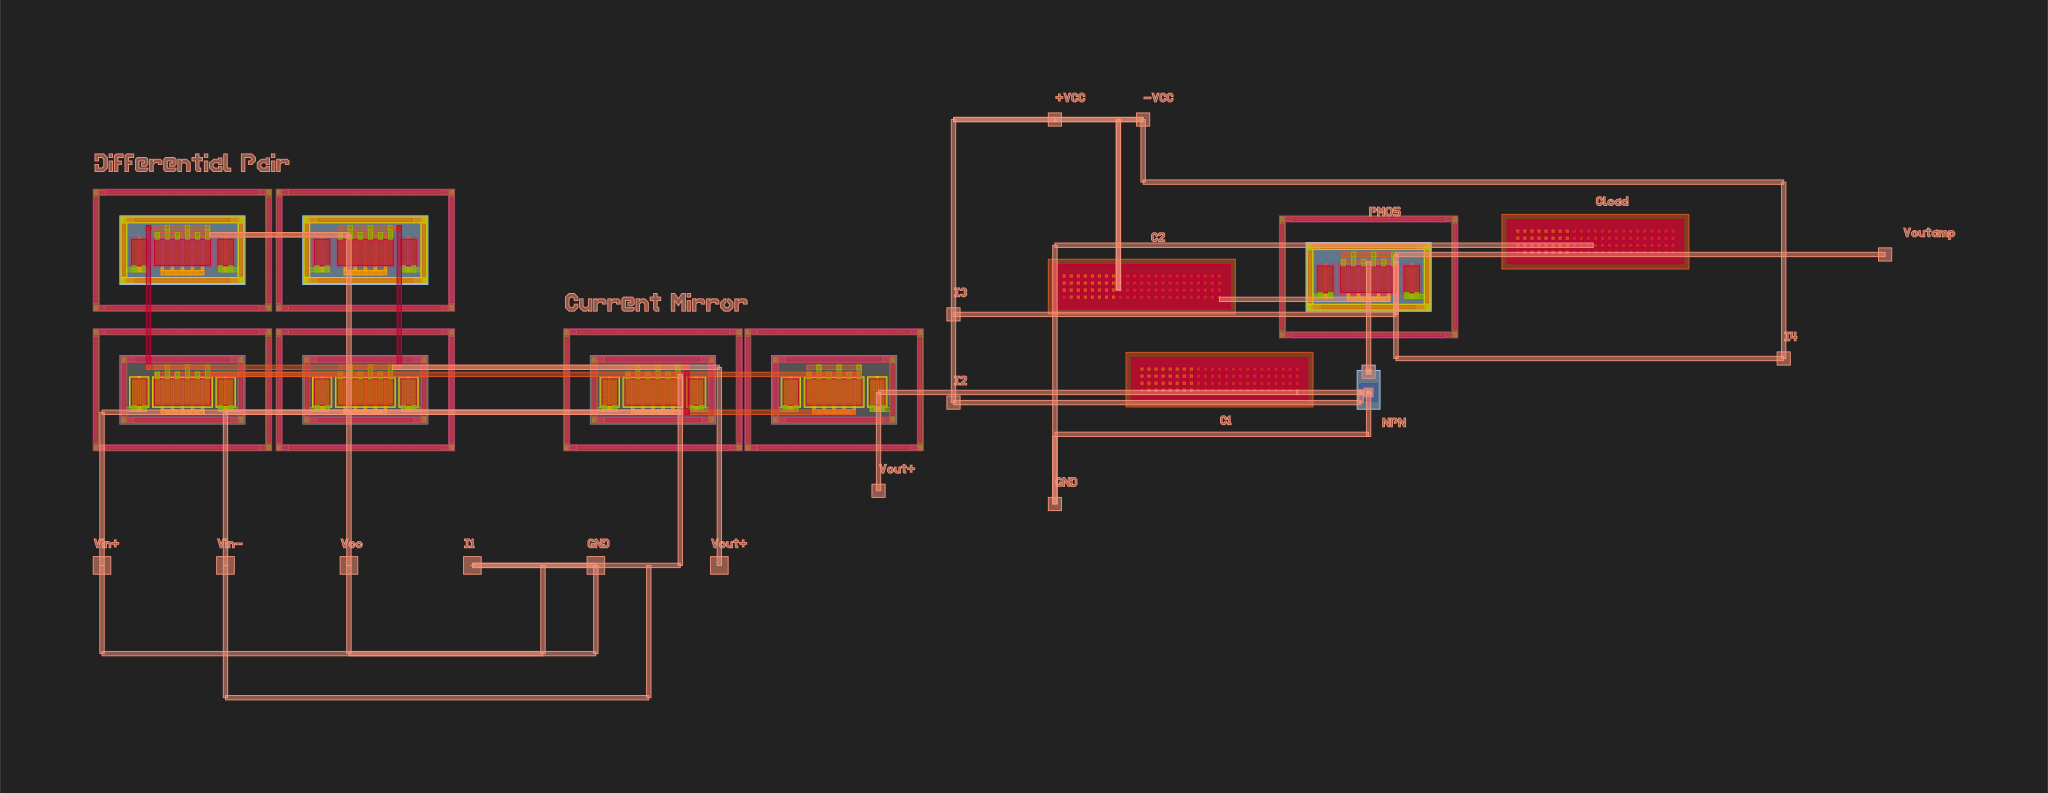

/tmp/ipykernel_1023/1941695118.py:69: UserWarning: Unnamed cells, 8 in 'combined_stage1_stage2'
  combined.write_gds("combine.gds")
2025-07-12 07:22:41.881 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'combine.gds'


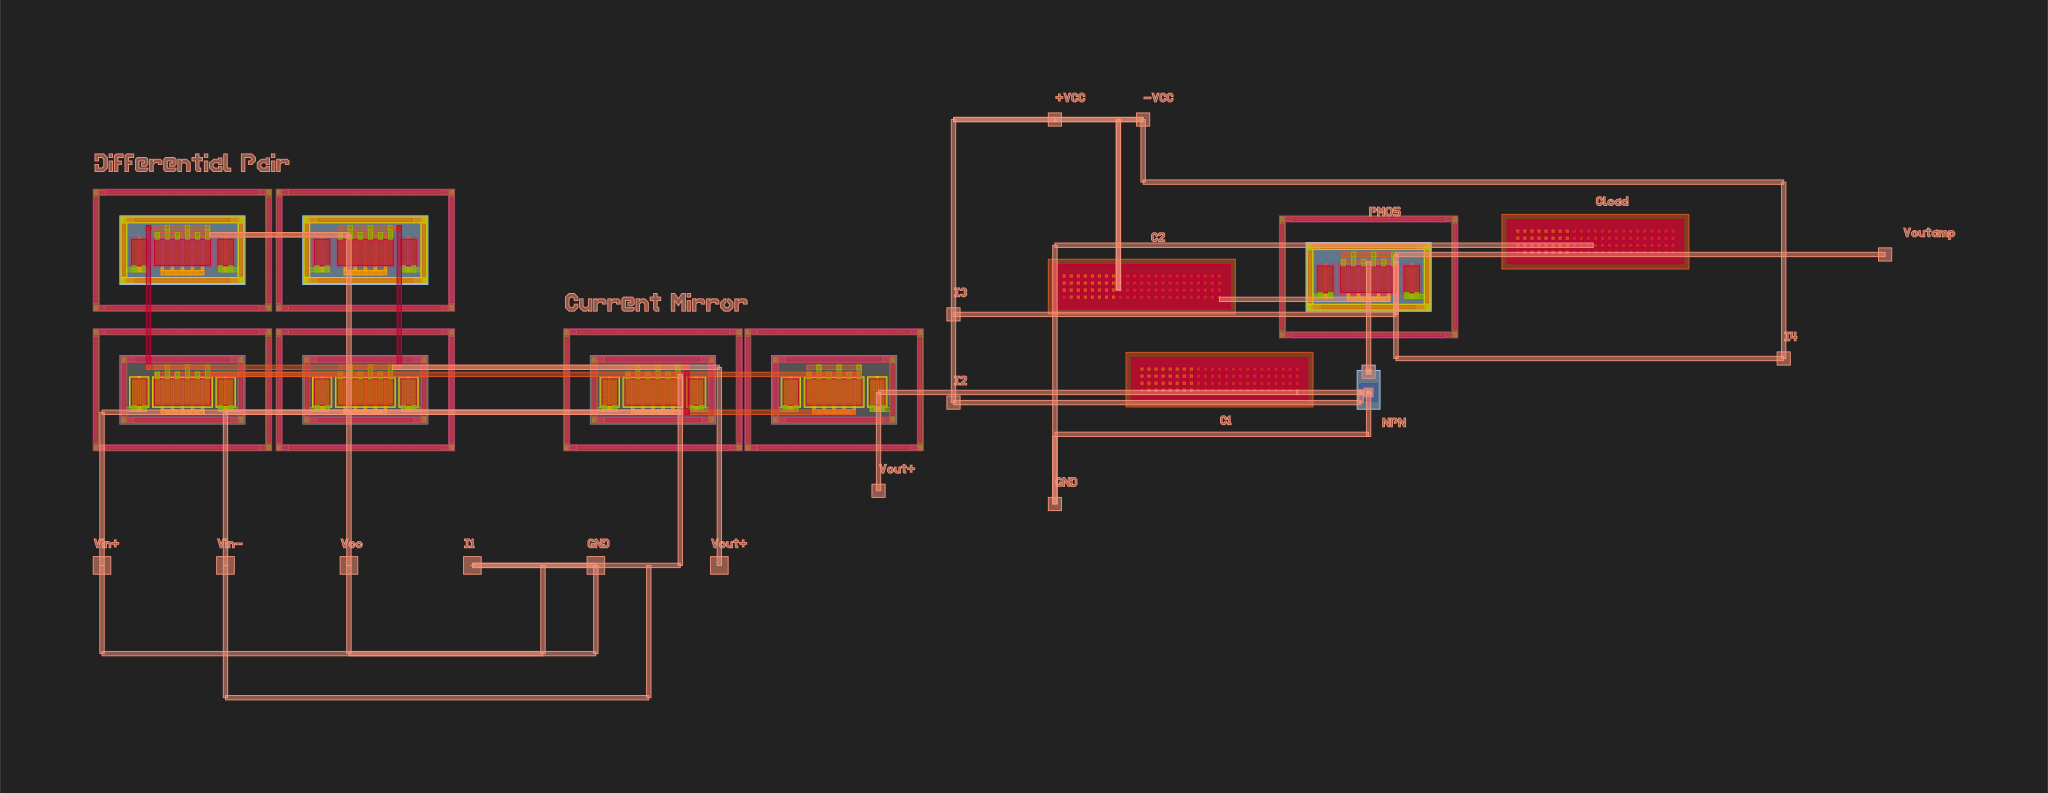

/headless/conda-env/miniconda3/envs/GLdev/lib/python3.10/site-packages/gdsfactory/show.py:40: UserWarning: Unnamed cells, 8 in 'combined_stage1_stage2'
  gdspath = component.write_gds(
2025-07-12 07:22:48.239 | WARNING  | gdsfactory.klive:show:57 - klive didn't send data, closing


In [25]:
# Cell 9: Final Routing
from gdsfactory import Component, components as c
def combine_stage1_stage2(stage1: Component, stage2: Component) -> Component:
    top = Component("combined_stage1_stage2")
    ref1 = top << stage1
    ref2 = top << stage2

    spacing = 30
    w1 = stage1.bbox[1][0] - stage1.bbox[0][0]
    ref2.movex(w1 + spacing)

    trace_width = 0.5
    metal_layer = (68, 20)

    # RoutingL I1 (Stage 1 output) to C1 (top of MIM1 in Stage 2)
    try:
        p1 = ref1.ports["I1"].center  # Stage 1 current mirror output

        # Find top port of MIM1 (C1) in stage 2
        c1_top_candidates = [p for p in ref2.ports.values() if "top" in p.name.lower()]
        if not c1_top_candidates:
            raise ValueError("No top port found on C1 in stage 2.")
        p2 = c1_top_candidates[0].center  # Assume first match is correct

        # Horizontal segment
        h = c.rectangle(size=(abs(p1[0] - p2[0]), trace_width), layer=metal_layer)
        h_ref = top << h
        h_ref.move((min(p1[0], p2[0]), p1[1] - trace_width / 2))

        # Vertical segment
        v = c.rectangle(size=(trace_width, abs(p1[1] - p2[1])), layer=metal_layer)
        v_ref = top << v
        v_ref.move((p2[0] - trace_width / 2, min(p1[1], p2[1])))

        print(f"Connected I1 to {c1_top_candidates[0].name}")

    except Exception as e:
        print(f"")

    # RoutingL Vout+ PAD (Stage 2) to PMOS DRAIN (Stage 1)
    try:
        # Stage 2: external Vout+ pad
        vp2 = ref2.ports["Vout+_pad"].center

        # Stage 1: internal PMOS drain (from differential pair)
        vp1 = ref1.ports["Vout+"].center

        # Horizontal segment
        h = c.rectangle(size=(abs(vp1[0] - vp2[0]), trace_width), layer=metal_layer)
        h_ref = top << h
        h_ref.move((min(vp1[0], vp2[0]), vp1[1] - trace_width / 2))

        # Vertical segment if needed
        if vp1[1] != vp2[1]:
            v = c.rectangle(size=(trace_width, abs(vp1[1] - vp2[1])), layer=metal_layer)
            v_ref = top << v
            v_ref.move((vp2[0] - trace_width / 2, min(vp1[1], vp2[1])))

        print("Connected Vout+ pad (stage2) → PMOS drain (stage1)")

    except Exception as e:
        print(f"")

    return top

# Combine and display to klayout
combined = combine_stage1_stage2(stage1=top1, stage2=top2)
display_component(combined, scale=3)
combined.write_gds("combine.gds")
display_gds("combine.gds")
combined.show()